# Structure from Motion


In [1]:
import numpy as np
import cv2
import os
from plyfile import PlyData, PlyElement
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Load Images


In [2]:
def find_and_track_features(images):
    sift = cv2.SIFT_create()
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    keypoints = []
    descriptors = []
    tracks = []

    for i, gray in enumerate(images):
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        keypoints.append(kp)
        descriptors.append(des)

        if i == 0:
            prev_gray = gray
            prev_kp = np.array([x.pt for x in kp],
                               dtype=np.float32).reshape(-1, 1, 2)
            for _ in kp:
                tracks.append([])
        else:
            next_kp, status, _ = cv2.calcOpticalFlowPyrLK(
                prev_gray, gray, prev_kp, None, **lk_params)
            status = status.ravel()

            for j, (prev_pt, next_pt) in enumerate(zip(prev_kp, next_kp)):
                if status[j]:
                    tracks[j].append((i, tuple(next_pt.ravel())))

            prev_gray = gray
            prev_kp = next_kp[status == 1]

    return tracks, keypoints, descriptors


def factorization_method(tracks):
    track_lens = [len(track) for track in tracks]
    max_len = max(track_lens)
    valid_tracks = [track for track in tracks if len(track) == max_len]

    W = np.zeros((2 * max_len, len(valid_tracks)), dtype=np.float32)

    for j, track in enumerate(valid_tracks):
        for i, (_, pt) in enumerate(track):
            W[2 * i, j] = pt[0]
            W[2 * i + 1, j] = pt[1]

    U, S, Vt = np.linalg.svd(W)
    U_3xN = U[:, :3]
    S_3x3 = np.diag(S[:3])
    V_3xP = Vt[:3, :]

    M = U_3xN @ np.sqrt(S_3x3)
    S = np.sqrt(S_3x3) @ V_3xP

    return S.T


def save_ply_file(coordinates_3D, output_file):
    num_points = coordinates_3D.shape[0]
    header = f"""ply
                    format ascii 1.0
                    element vertex {num_points}
                    property float x
                    property float y
                    property float z
                    end_header
                    """

    with open(output_file, 'w') as f:
        f.write(header)
        for point in coordinates_3D:
            f.write(f"{point[0]} {point[1]} {point[2]}\n")


def plot_tracked_features(images, tracks, nums, grid_size=(5, 5)):
    num_images = min(nums, grid_size[0] * grid_size[1], len(images)
                     ) if nums else min(nums, grid_size[0] * grid_size[1], len(images))
    print(num_images, grid_size[0] * grid_size[1], nums)
    fig, axes = plt.subplots(*grid_size, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_images):

        img = images[i].copy()
        for track in tracks:
            if len(track) > i:
                cv2.circle(img, tuple(
                    map(int, track[i][1])), 3, (0, 255, 0), -1)
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis('off')

    # Remove empty subplots
    for j in range(num_images, grid_size[0] * grid_size[1]):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_trackings(images, tracks, nums):
    for i in range(len(images) - 1):
        if i >= nums:
            break
        img1 = images[i].copy()
        img2 = images[i + 1].copy()
        h1, w1, _ = img1.shape
        h2, w2, _ = img2.shape

        img_concat = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
        img_concat[:h1, :w1, :] = img1
        img_concat[:h2, w1:, :] = img2

        for track in tracks:
            if len(track) > i + 1:
                pt1 = tuple(map(int, track[i][1]))
                pt2 = tuple(map(int, track[i + 1][1]))

                cv2.circle(img_concat, pt1, 3, (0, 255, 0), -1)
                cv2.circle(
                    img_concat, (pt2[0] + w1, pt2[1]), 3, (0, 255, 0), -1)

                pt2_shifted = (pt2[0] + w1, pt2[1])
                cv2.line(img_concat, pt1, pt2_shifted, (0, 0, 255), 1)

        plt.figure(figsize=(16, 6))
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.title(
            f"Tracked Features and Connections Between Frame {i+1} and {i+2}")
        plt.show()


def plot_3d_coordinates(coordinates_3D):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    xs, ys, zs = coordinates_3D.T
    ax.scatter(xs, ys, zs, marker='o', color='b')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("3D Scatter Plot of the Recovered Points")
    plt.show()


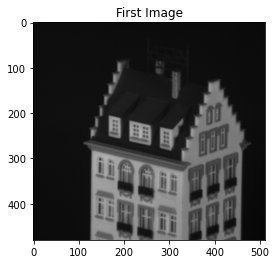

In [3]:
# Load the CMU Hotel Sequence images
image_folder = './hotel/'
images = [cv2.imread(file) for file in glob.glob(image_folder+'*.png')]

plt.figure()
plt.imshow(images[0])
plt.title("First Image")
plt.show()


3 25 3


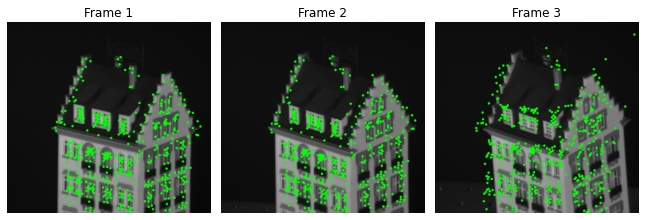

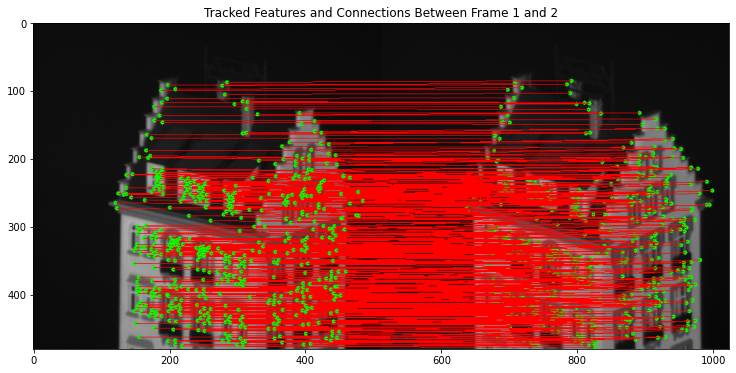

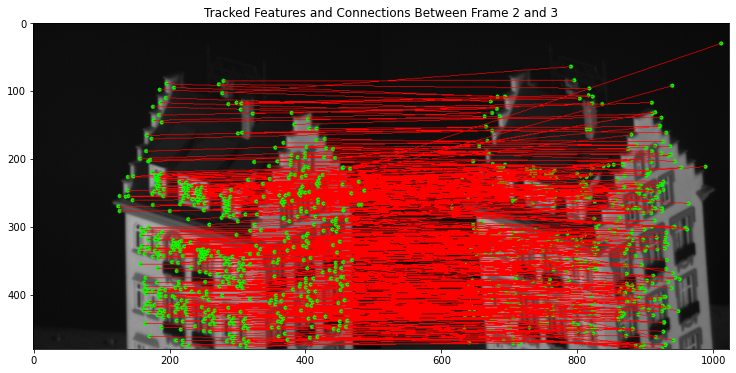

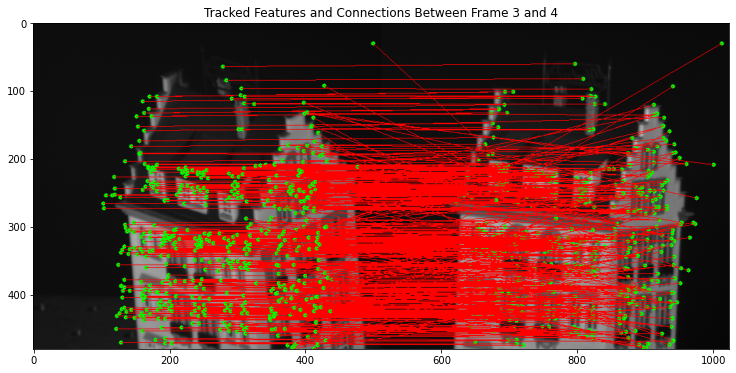

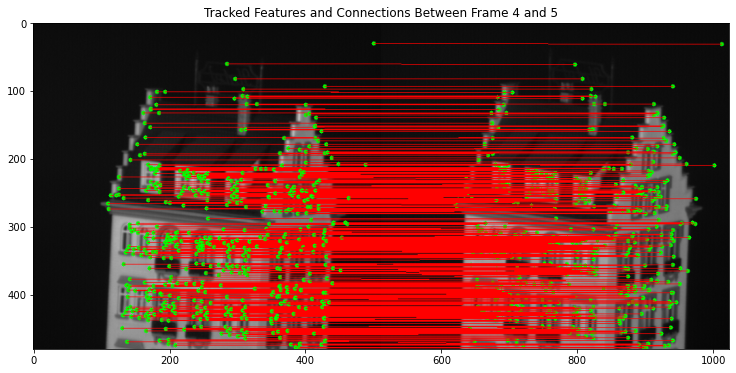

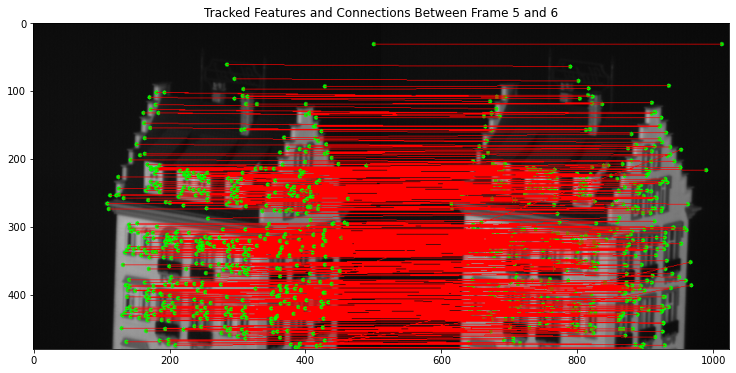

In [4]:
# Find and track features
tracks, keypoints, descriptors = find_and_track_features(images)

# Plot the tracked features
plot_tracked_features(images, tracks, nums=3)

# Plot the tracking
plot_trackings(images, tracks, nums=5)


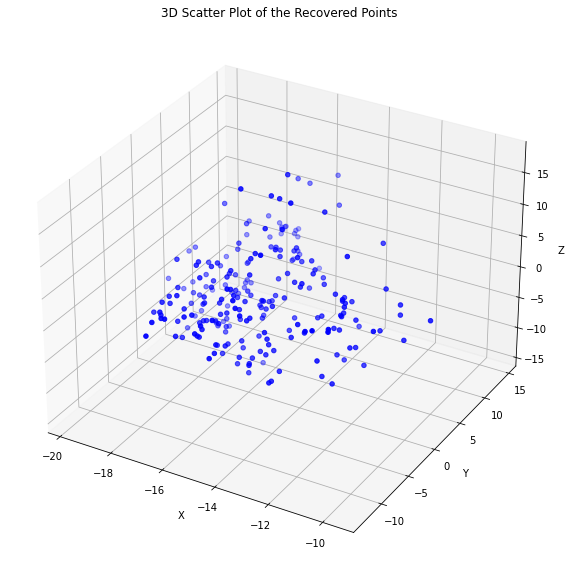

In [5]:
# Apply the factorization method
coordinates_3D = factorization_method(tracks)

# Plot the 3D coordinates
plot_3d_coordinates(coordinates_3D)


In [6]:
# Step 2: Create an ASCII output PLY file
output_file = 'output.ply'
save_ply_file(coordinates_3D, output_file)

# Step 3: Test your algorithm on the CMU Hotel Sequence
print("PLY file saved at:", output_file)


PLY file saved at: output.ply
